# Load and setup the data and variables

In [1]:
expr_mouse = "../../data/prepared/mouse_scaled.tsv.gz"
expr_human = "../../data/prepared/human_scaled.tsv.gz"
conservation = "../../data/prepared/aucs.tsv.gz"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import preprocessing, decomposition

In [3]:
aurocs = pd.read_csv(conservation, sep="\t", index_col=0).mean(axis=1)
aurocs.rename('auroc', inplace=True)

SLC39A1    0.521690
SCAMP2     0.247573
LYRM7      0.546687
SYVN1      0.420172
SHC4       0.272679
             ...   
DOCK9      0.258718
PLXNB2     0.272631
RGS8       0.399987
CCNO       0.499295
ACOT7      0.296424
Name: auroc, Length: 11139, dtype: float64

In [4]:
mouse = pd.read_csv(expr_mouse, sep="\t", header=0, index_col=[0,1])
human = pd.read_csv(expr_human, sep="\t", header=0, index_col=[0,1])
mouse.head().iloc[:,:5]

Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

In [5]:
mouse.shape

(280, 19074)

In [6]:
human.shape

(111, 12383)

We have to capitalize all of the mouse gene names.

In [7]:
mouse.columns = [gene.upper() for gene in mouse.columns]
human.columns = [gene.upper() for gene in human.columns]
mouse.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE', 'AC132444.5',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=19074)

We're only interested in genes that are shared between the two species.

In [8]:
genes = list(set(mouse.columns).intersection(human.columns))
len(genes)

11139

In [9]:
mouse_genes = mouse.loc[:,genes]
human_genes = human.loc[:,genes]
human_genes.shape

(111, 11139)

Let's rescale across samples now that we've excluded some genes.

In [10]:
mouse_genes = mouse_genes.divide(mouse_genes.sum(axis=1), axis=0)*1e6
human_genes = human_genes.divide(human_genes.sum(axis=1), axis=0)*1e6
mouse_genes.head().iloc[:,:5]

COA6       MCCC1      CORO2A      SEC24A      OTOG
celltype donor_id                                                         
E_1      F003      79.787047   99.719300  111.180222  137.917173  1.535126
         F004      85.482686   99.740634  108.813212  137.357030  2.279836
         F005      81.770430   92.510796  114.085051  141.430319  1.039693
         F006      82.373231   95.529875  113.345765  140.461599  3.968452
         F007      85.012073  100.713263  112.933745  140.587744  2.547392

# Obtain the mean expression over samples in each celltype

In [11]:
mean_mouse = mouse_genes.groupby('celltype').mean().T
mean_mouse.index.names = ['gene']
mean_human = human_genes.groupby('celltype').mean().T
mean_human.index.names = ['gene']
mean_mouse.head().iloc[:,:5]

celltype,E_1,E_10,E_11,E_12,E_14
gene,,,,,
COA6,86.504776,80.148212,97.299438,81.227120,78.736895
MCCC1,97.365633,106.032888,102.129678,105.347869,101.522265
CORO2A,111.308422,109.630846,126.043238,110.775401,116.058198
SEC24A,138.218327,141.000325,141.220058,125.268270,141.813100
OTOG,3.406745,2.946390,3.047990,4.029504,5.873843


In [12]:
mean_mouse.shape

(11139, 33)

In [13]:
mean_human.shape

(11139, 58)

Let's also merge the data into a single dataframe.

In [14]:
def merge_dfs(expr, aurocs):
    return expr.merge(aurocs, left_index=True, right_index=True)

In [15]:
full_mouse = merge_dfs(mean_mouse, aurocs)
full_human = merge_dfs(mean_human, aurocs)
full_mouse.head().iloc[:,-5:]

,N_4,N_5,N_6,N_7,auroc
COA6,79.505559,80.913185,95.699093,97.320501,0.534480
MCCC1,93.459622,102.811548,78.071537,114.833691,0.395060
CORO2A,131.288012,27.136771,118.276224,35.268699,0.490355
SEC24A,140.051335,132.177066,119.275241,112.827090,0.489466
OTOG,1.040071,6.471972,0.000000,1.842501,0.520447


# Perform a basic regression without correcting for anything

In [16]:
def multiple_reg(expr, full_expr):
    sumstats = {}
    for celltype in expr.columns:
        model = smf.ols(formula=f"{celltype} ~ auroc", data=full_expr)
        res = model.fit()
        sumstats[celltype] = res.summary2().tables[1].loc['auroc']
    sumstats = pd.DataFrame(sumstats).T
    sumstats.index.names = ['celltype']
    sumstats.columns = ['beta', 'stderr', 't', 'pval', 'CI_start', 'CI_end']
    return sumstats

In [17]:
mouse_res = multiple_reg(mean_mouse, full_mouse)
mouse_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,82.423015,3.996945,20.621505,9.396040e-93,74.588296,90.257734
E_10,76.551882,3.962917,19.317055,8.349462e-82,68.783863,84.319900
E_11,84.058203,4.146791,20.270662,9.610085e-90,75.929758,92.186647
E_12,73.141438,4.092515,17.872003,1.870087e-70,65.119384,81.163492
E_14,76.397451,3.964780,19.269026,2.051700e-81,68.625780,84.169122


In [18]:
human_res = multiple_reg(mean_human, full_human)
human_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,59.726346,4.012363,14.885579,1.225496e-49,51.861404,67.591287
E_10,61.248746,3.837877,15.959015,1.046602e-56,53.725826,68.771665
E_11,59.311525,3.941643,15.047412,1.128753e-50,51.585207,67.037843
E_12,62.654775,4.089091,15.322420,1.854171e-52,54.639432,70.670118
E_13,57.767353,3.907285,14.784526,5.365839e-49,50.108383,65.426323


# Plot the distribution of the expression correlation matrix

In [19]:
def offdiag(corr):
    offdiag_idxs = np.where(~np.eye(corr.shape[0],dtype=bool))
    return corr[offdiag_idxs]

In [20]:
def sample_corr(expr):
    corr = np.corrcoef(expr, expr)[:expr.shape[0], :expr.shape[0]]
    return corr

In [21]:
def plot_corr(expr):
    corr_offdiag = offdiag(sample_corr(expr))
    _, bins, ax = plt.hist(corr_offdiag, bins=1000, density=True)
    plt.plot(bins, norm.pdf(bins, 0, 1/np.sqrt(expr.shape[1]-2)))

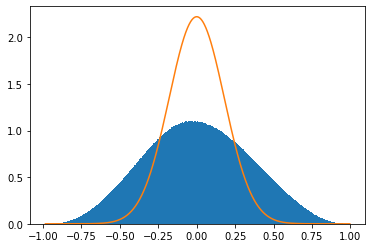

In [22]:
plot_corr(mean_mouse.values)

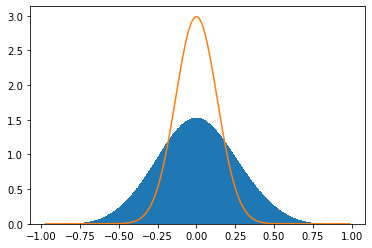

In [23]:
plot_corr(mean_human.values)

# Scale the gene expression values

Seems like there's some correlation. Can we reduce it by scaling the values?

In [24]:
def scale_expr(expr):
    return expr.subtract(expr.mean(axis=1), axis=0).divide(expr.std(axis=1), axis=0)

In [25]:
mouse_scaled = scale_expr(mean_mouse)
human_scaled = scale_expr(mean_human)
mouse_scaled.shape

(11139, 33)

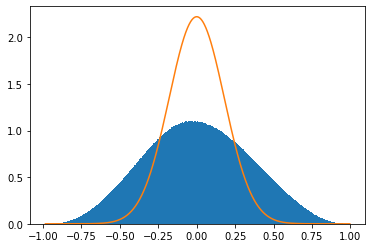

In [26]:
plot_corr(mouse_scaled)

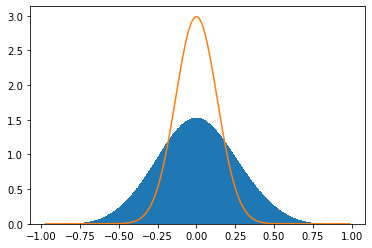

In [27]:
plot_corr(human_scaled)

# Correct for gene correlation by regressing out PCs

Let's first obtain the PCs of each expression matrix.

In [52]:
def get_PCs(expr):
    pca = decomposition.PCA(svd_solver='full')
    pca.fit(expr.T)
    exp_var = pca.explained_variance_
    plt.scatter(range(len(exp_var)), exp_var)
    return pca

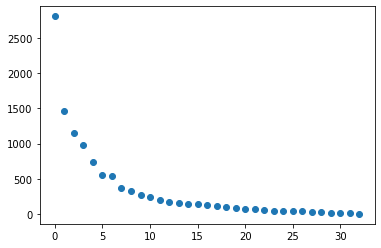

In [53]:
mouse_pca = get_PCs(mouse_scaled)

In [132]:
pcs_10 = mouse_pca.components_[:33, :]

In [133]:
mouse_pca.components_.shape

(33, 11139)

In [134]:
pcs_10.shape

(33, 11139)

In [135]:
aurocs

SLC39A1    0.521690
SCAMP2     0.247573
LYRM7      0.546687
SYVN1      0.420172
SHC4       0.272679
             ...   
DOCK9      0.258718
PLXNB2     0.272631
RGS8       0.399987
CCNO       0.499295
ACOT7      0.296424
Name: auroc, Length: 11139, dtype: float64

In [136]:
aurocs.values.reshape(-1, 1).T.shape

(1, 11139)

In [137]:
check_pcs = np.append(pcs_10, aurocs.values.reshape(-1, 1).T, 0)

In [138]:
check_pcs.shape

(34, 11139)

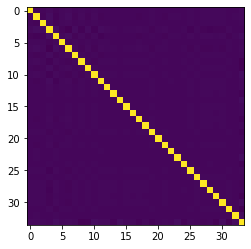

In [139]:
plt.imshow(np.corrcoef(check_pcs))

In [148]:
pcs_10 = human_pca.components_[:10, :]

In [149]:
mouse_pca.components_.shape

(33, 11139)

In [150]:
pcs_10.shape

(10, 11139)

In [151]:
aurocs

SLC39A1    0.521690
SCAMP2     0.247573
LYRM7      0.546687
SYVN1      0.420172
SHC4       0.272679
             ...   
DOCK9      0.258718
PLXNB2     0.272631
RGS8       0.399987
CCNO       0.499295
ACOT7      0.296424
Name: auroc, Length: 11139, dtype: float64

In [152]:
aurocs.values.reshape(-1, 1).T.shape

(1, 11139)

In [153]:
check_pcs = np.append(pcs_10, aurocs.values.reshape(-1, 1).T, 0)

In [156]:
pd.DataFrame(aurocs, 

SLC39A1    0.521690
SCAMP2     0.247573
LYRM7      0.546687
SYVN1      0.420172
SHC4       0.272679
             ...   
DOCK9      0.258718
PLXNB2     0.272631
RGS8       0.399987
CCNO       0.499295
ACOT7      0.296424
Name: auroc, Length: 11139, dtype: float64

In [154]:
check_pcs.shape

(11, 11139)

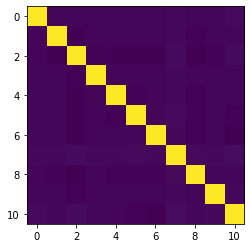

In [155]:
plt.imshow(np.corrcoef(check_pcs))

In [103]:
pd.DataFrame(np.corrcoef(check_pcs))

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,-0.004246,-0.002363,0.008228,-0.005697,0.001084,0.004856,-0.002616,0.002774,-0.002454,0.008229
1,-0.004246,1.000000,-0.004678,0.016290,-0.011279,0.002146,0.009614,-0.005179,0.005492,-0.004859,0.007713
2,-0.002363,-0.004678,1.000000,0.009065,-0.006277,0.001194,0.005350,-0.002882,0.003056,-0.002704,0.000782
3,0.008228,0.016290,0.009065,1.000000,0.021857,-0.004158,-0.018629,0.010037,-0.010642,0.009416,0.000332
4,-0.005697,-0.011279,-0.006277,0.021857,1.000000,0.002879,0.012899,-0.006949,0.007369,-0.006520,0.013123
5,0.001084,0.002146,0.001194,-0.004158,0.002879,1.000000,-0.002454,0.001322,-0.001402,0.001240,0.001782
6,0.004856,0.009614,0.005350,-0.018629,0.012899,-0.002454,1.000000,0.005923,-0.006280,0.005557,0.008205
7,-0.002616,-0.005179,-0.002882,0.010037,-0.006949,0.001322,0.005923,1.000000,0.003384,-0.002994,0.002380
8,0.002774,0.005492,0.003056,-0.010642,0.007369,-0.001402,-0.006280,0.003384,1.000000,0.003174,-0.019299
9,-0.002454,-0.004859,-0.002704,0.009416,-0.006520,0.001240,0.005557,-0.002994,0.003174,1.000000,-0.013251


In [78]:
np.corrcoef(check_pcs)

1.0

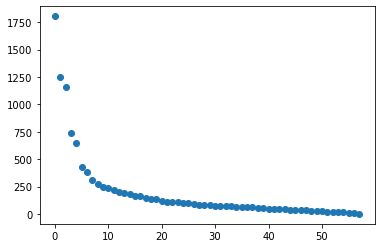

In [57]:
human_pca = get_PCs(human_scaled)

Seems like the first PC captures most of the variance.

In [60]:
def regress_PCs(pca, expr, num_PCs=10):
    transformed = pca.transform(expr.T)
    transformed[:,num_PCs:] = 0
    pc1_vals = pca.inverse_transform(transformed)
    return expr - pc1_vals.T

In [61]:
mouse_resid = regress_PCs(mouse_pca, mouse_scaled)
mouse_resid.shape

(11139, 33)

In [62]:
human_resid = regress_PCs(human_pca, human_scaled)
human_resid.shape

(11139, 58)

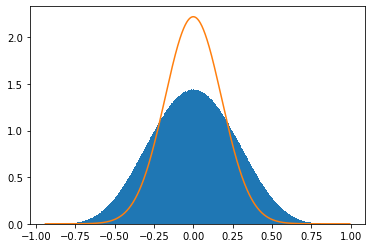

In [63]:
plot_corr(mouse_resid.values)

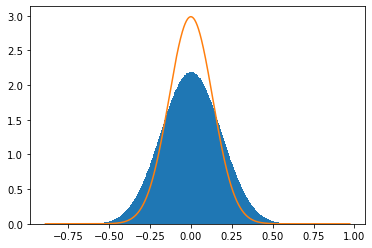

In [64]:
plot_corr(human_resid.values)

# Redo the regression with the residuals

In [157]:
mouse_pca_res = multiple_reg(mouse_resid, merge_dfs(mouse_resid, aurocs))
human_pca_res = multiple_reg(human_resid, merge_dfs(human_resid, aurocs))
mouse_pca_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,0.095134,0.033562,2.834548,0.004597,0.029346,0.160922
E_10,0.064318,0.031590,2.036057,0.041768,0.002397,0.126239
E_11,0.067192,0.040026,1.678728,0.093233,-0.011265,0.145649
E_12,-0.038582,0.044501,-0.866996,0.385963,-0.125812,0.048648
E_14,0.010842,0.027932,0.388153,0.697910,-0.043909,0.065593


Subset to just the significant celltypes.

In [158]:
alpha = 0.05

In [159]:
mouse_sig = mouse_pca_res[mouse_pca_res['pval'] < alpha]
human_sig = human_pca_res[human_pca_res['pval'] < alpha]
print(len(mouse_sig), len(human_sig)) # how many significant celltypes are there?

12 19


In [160]:
mouse_sig

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,0.095134,0.033562,2.834548,0.004597,0.029346,0.160922
E_10,0.064318,0.031590,2.036057,0.041768,0.002397,0.126239
E_3,-0.108745,0.025284,-4.300970,0.000017,-0.158306,-0.059184
E_5,0.107117,0.031107,3.443486,0.000576,0.046142,0.168093
I_1,-0.122590,0.048939,-2.504968,0.012260,-0.218518,-0.026661
I_10,-0.094562,0.040715,-2.322518,0.020223,-0.174372,-0.014753
I_12,0.086752,0.027166,3.193335,0.001410,0.033501,0.140003
I_21,0.088851,0.030965,2.869367,0.004121,0.028153,0.149549
I_3,0.056199,0.027326,2.056595,0.039748,0.002635,0.109762


In [161]:
human_sig

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,0.099219,0.038411,2.583105,9.804185e-03,0.023927,0.174510
E_10,-0.141554,0.036226,-3.907515,9.380181e-05,-0.212564,-0.070545
E_12,0.118146,0.055221,2.139505,3.241643e-02,0.009903,0.226389
E_15,-0.082765,0.037056,-2.233524,2.553418e-02,-0.155401,-0.010129
E_2,-0.253245,0.052135,-4.857469,1.205143e-06,-0.355439,-0.151051
E_20,0.260135,0.041044,6.337985,2.417863e-10,0.179682,0.340589
E_22,0.143248,0.052184,2.745073,6.059440e-03,0.040959,0.245538
E_5,-0.075003,0.029614,-2.532651,1.133396e-02,-0.133052,-0.016953
E_7,0.146718,0.039417,3.722228,1.984449e-04,0.069454,0.223982


In [163]:
mouse_pca_res.to_csv('../../data/prepared/mouse_regression_results.tsv', sep='\t')

In [164]:
human_pca_res.to_csv('../../data/prepared/human_regression_results.tsv', sep='\t')

Which of the significant celltypes are shared between species?

In [162]:
set(mouse_sig.index).intersection(human_sig.index)

{'E_1', 'E_10', 'E_5', 'I_21', 'I_3', 'I_4'}

# Correct for multiple hypothesis testing
Let's perform an FDR correction.

First, let's plot the distribution of the t-statistics.

<AxesSubplot:>

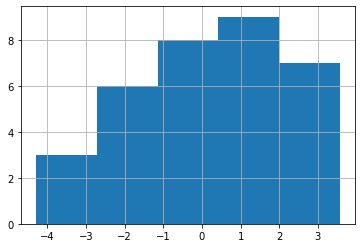

In [71]:
mouse_pca_res['t'].hist(bins=5)

<AxesSubplot:>

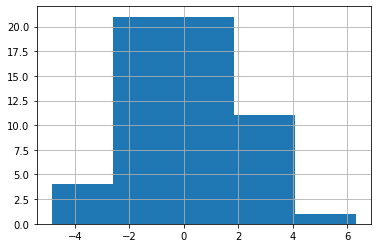

In [72]:
human_pca_res['t'].hist(bins=5)